# Model metrics :

> Open DF : 

In [ ]:
import pandas as pd 
import os 

path_seqbased = "/media/concha-eloko/Linux/PPT_clean/RF_2912_models_info"

header_metric = ["KL_type", "Effectifs","MCC","F1","recall","Accuracy","AUC"]
seqbased_df = pd.read_csv(f"{path_seqbased}/RF_report.0.75.2912.tsv", sep = "\t", names = header_metric)

In [ ]:
df_metrics_sorted = seqbased_df.sort_values(by='KL_type', key=lambda x: x.str.split("KL").str[1].astype(int))
for col in df_metrics_sorted.columns : 
    if col not in ["KL_type","n_prophages"] : 
        df_metrics_sorted[col] = round(df_metrics_sorted[col] , 4)

> Compute metrics 

In [ ]:
g1_group = ["KL2", "KL17", "KL47", "KL64", "KL106", "KL107"]
g2_group = ["KL1", "KL3", "KL14", "KL15", "KL23", "KL24", "KL25", "KL27", "KL51", "KL62", "KL102"]

big_groups = g1_group + g2_group

g3_group = [kltype for kltype in df_metrics_sorted["KL_type"].tolist() if kltype not in big_groups]

In [ ]:
import statistics

mcc_g1 = [float(row["MCC"]) for _,row in df_metrics_sorted.iterrows() if row["KL_type"] in g1_group]
mean_g1 = statistics.mean(mcc_g1)
std_g1 = statistics.stdev(mcc_g1)


mcc_g2 = [float(row["MCC"]) for _,row in df_metrics_sorted.iterrows() if row["KL_type"] in g2_group]
mean_g2 = statistics.mean(mcc_g2)
std_g2 = statistics.stdev(mcc_g2)


mcc_g3 = [float(row["MCC"]) for _,row in df_metrics_sorted.iterrows() if row["KL_type"] in g3_group]
mean_g3 = statistics.mean(mcc_g3)
std_g3 = statistics.stdev(mcc_g3)

In [ ]:
round(mean_g3, 4) , round(std_g3 , 4)

***
# Get the attention weights :

In [ ]:
rsync -avzhe ssh \
/media/concha-eloko/Linux/PPT_clean/TropiGATv2.final_df_v2.filtered.tsv \
conchae@garnatxa.srv.cpd:/home/conchae/prediction_depolymerase_tropism/prophage_prediction/depolymerase_decipher/ficheros_28032023/train_nn \



In [1]:
from torch_geometric.data import HeteroData, DataLoader
import torch_geometric.transforms as T
from torch_geometric.nn import to_hetero , HeteroConv , GATv2Conv
from torch_geometric.utils import negative_sampling
from torch_geometric.loader import LinkNeighborLoader
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder , label_binarize , OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score , matthews_corrcoef

import TropiGAT_functions 
import TropiGAT_graph
#from TropiGAT_functions import get_top_n_kltypes ,clean_print 

import os
import json
import pandas as pd
import numpy as np
from tqdm import tqdm
from itertools import product
import random
from collections import Counter
import warnings
import logging
from multiprocessing.pool import ThreadPool
warnings.filterwarnings("ignore")

# *****************************************************************************
# Load the Dataframes :
path_work = "/media/concha-eloko/Linux/PPT_clean"
path_ensemble = f"{path_work}/ficheros_28032023/winning_ensemble_0702"

In [2]:
DF_info = pd.read_csv(f"{path_work}/TropiGATv2.final_df_v2.filtered.tsv", sep = "\t" ,  header = 0)
DF_info_lvl_0 = DF_info.copy()
df_prophages = DF_info_lvl_0.drop_duplicates(subset = ["Phage"])
dico_prophage_count = dict(Counter(df_prophages["KL_type_LCA"]))


#path_work = "/home/conchae/prediction_depolymerase_tropism/prophage_prediction/depolymerase_decipher/ficheros_28032023"
#DF_info = pd.read_csv(f"{path_work}/train_nn/TropiGATv2.final_df_v2.filtered.tsv", sep = "\t" ,  header = 0)



In [ ]:
DF_info_lvl_0.columns

In [3]:
def make_ensemble_TropiGAT_attention(path_ensemble) : 
	"""
	This function builds a dictionary with all the models that are part of the TropiGAT predictor
	Input : Path of the models
	Output : Dictionary , attention weights
	# Make a json file with the versions of the GNN corresponding to each KL types
	# Load it
	# Create the correct model instance (TropiGAT_small_module or TropiGAT_big_module)
	"""
	errors = []
	DF_info = pd.read_csv(f"{path_work}/TropiGATv2.final_df_v2.filtered.tsv", sep = "\t" ,  header = 0)
	DF_info_lvl_0 = DF_info.copy()
	df_prophages = DF_info_lvl_0.drop_duplicates(subset = ["Phage"])
	dico_prophage_count = dict(Counter(df_prophages["KL_type_LCA"]))
	dico_ensemble = {}
	for GNN_model in os.listdir(path_ensemble) :
		if GNN_model[-2:] == "pt" :
			KL_type = GNN_model.split(".")[0]
			try :
				if dico_prophage_count[KL_type] >= 125 : 
					model = TropiGAT_models.TropiGAT_big_module_attention(hidden_channels = 1280 , heads = 1)
				else :
					model = TropiGAT_models.TropiGAT_small_module_attention(hidden_channels = 1280 , heads = 1)
				model.load_state_dict(torch.load(f"{path_ensemble}/{GNN_model}"))
				dico_ensemble[KL_type] = model
			except Exception as e :
				a = (KL_type , dico_prophage_count[KL_type], e)
				errors.append(a)
	return dico_ensemble , errors
    
@torch.no_grad()
def make_predictions(model, data):
	model.eval() 
	output, weigths = model(data)
	probabilities = torch.sigmoid(output)
	predictions = probabilities.round() 
	return predictions, probabilities , weigths


def run_prediction_attentive(dico_graph, dico_ensemble, KL_type) :
    dico_predictions = {}
    query_graph = dico_graph[KL_type]["graph"]
    model = dico_ensemble[KL_type]
    prediction, probabilities, weights = make_predictions(model, query_graph)
    dico_predictions[KL_type] = {"probabilitites" : probabilities, "weights" : weights}
    return dico_predictions

In [4]:
dico_models, errors = TropiGAT_functions.make_ensemble_TropiGAT_attention(path_ensemble)
#dico_models, errors = make_ensemble_TropiGAT_attention(path_ensemble)


In [5]:
#%% time
# *****************************************************************************
# Make graphs : 
graph_baseline , dico_prophage_kltype_associated = TropiGAT_graph.build_graph_baseline(DF_info_lvl_0)
graph_dico = {kltype : {"graph" : TropiGAT_graph.build_graph_masking(graph_baseline , dico_prophage_kltype_associated,DF_info_lvl_0, kltype, 0, 1, 0, 0), 
                        "positive_indices" : [index for index,kltype_ in enumerate(DF_info_lvl_0.drop_duplicates(subset = ["Phage"])["KL_type_LCA"].tolist()) if kltype_ == kltype]}
             for kltype in DF_info_lvl_0["KL_type_LCA"].unique()}

8871it [00:19, 448.49it/s]


In [9]:
attention_data = {}
for kltype in dico_models : 
    out_dico = run_prediction_attentive(graph_dico , dico_models, kltype)
    attention_data.update(out_dico)

#with open(f"{path_work}/attention_weights_dico.0802.json", "w") as outfile :
#    json.dump(attention_data , outfile)

In [7]:
attention_data_final = {}

for kltype in tqdm(attention_data) : 
    prophage_indices = graph_dico[kltype]["positive_indices"]
    tmp_dico = {}
    for _,prophage_index in enumerate(prophage_indices) :
        # If prediction is positive : 
        if attention_data[kltype]["probabilitites"][prophage_index] > 0.5 :
            prob = attention_data[kltype]["probabilitites"][prophage_index]
            real_prophage_name = DF_info["Phage"].unique().tolist()[prophage_index] 
            tmp_dpos = []
           # Look for the edges involving the prophage :
            for index_edge, prophage_edge in enumerate(attention_data[kltype]["weights"][0][1]) :
                if prophage_edge == prophage_index :
                    # Check the value of the attention coeff on the edge involving the prophage :
                    att_coeff = attention_data[kltype]["weights"][1][index_edge]
                    if att_coeff > 0.5 : 
                        # Get the seq of the depo : 
                        depo_index = attention_data[kltype]["weights"][0][0][index_edge]
                        real_depo_index = DF_info["index"].unique().tolist()[depo_index] 
                        seq = DF_info[DF_info["index"] == real_depo_index]["seq"].values[0]
                        domain_seq = DF_info[DF_info["index"] == real_depo_index]["domain_seq"].values[0]
                        # Pack the data :
                        a = (real_depo_index,seq,att_coeff, prob,domain_seq)
                        tmp_dpos.append(a)
        tmp_dico[real_prophage_name] = a
    attention_data_final[kltype] = tmp_dico
                        
                    
    

  0%|                                                    | 0/67 [00:00<?, ?it/s]


NameError: name 'a' is not defined

In [10]:
attention_data

{'KL105': {'probabilitites': tensor([0.0356, 0.0192, 0.0159,  ..., 0.9933, 0.4162, 0.0641]),
  'weights': (tensor([[   0, 2430,    1,  ..., 4032, 4033, 4034],
           [   0,    0,    1,  ..., 8868, 8869, 8870]]),
   tensor([[0.6150],
           [0.3850],
           [0.3914],
           ...,
           [1.0000],
           [1.0000],
           [1.0000]]))},
 'KL53': {'probabilitites': tensor([0.0592, 0.0657, 0.0822,  ..., 0.4726, 0.9376, 0.0495]),
  'weights': (tensor([[   0, 2430,    1,  ..., 4032, 4033, 4034],
           [   0,    0,    1,  ..., 8868, 8869, 8870]]),
   tensor([[0.4935],
           [0.5065],
           [0.3582],
           ...,
           [1.0000],
           [1.0000],
           [1.0000]]))},
 'KL5': {'probabilitites': tensor([0.0409, 0.0370, 0.0195,  ..., 0.0620, 0.0180, 0.0518]),
  'weights': (tensor([[   0, 2430,    1,  ..., 4032, 4033, 4034],
           [   0,    0,    1,  ..., 8868, 8869, 8870]]),
   tensor([[0.5000],
           [0.5000],
           [0.3333],


In [12]:
attention_data_raw = {}

for kltype in tqdm(attention_data) : 
    prophage_indices = graph_dico[kltype]["positive_indices"]
    tmp_dico = {}
    for _,prophage_index in enumerate(prophage_indices) :
        # If prediction is positive : 
        if attention_data[kltype]["probabilitites"][prophage_index] > 0.5 :
            prob = attention_data[kltype]["probabilitites"][prophage_index]
            real_prophage_name = DF_info["Phage"].unique().tolist()[prophage_index] 
            tmp_dpos = []
           # Look for the edges involving the prophage :
            for index_edge, prophage_edge in enumerate(attention_data[kltype]["weights"][0][1]) :
                if prophage_edge == prophage_index :
                    # Check the value of the attention coeff on the edge involving the prophage :
                    att_coeff = attention_data[kltype]["weights"][1][index_edge].float()
                    #if att_coeff > 0.5 : 
                    # Get the seq of the depo : 
                    depo_index = attention_data[kltype]["weights"][0][0][index_edge]
                    real_depo_index = DF_info["index"].unique().tolist()[depo_index] 
                    seq = DF_info[DF_info["index"] == real_depo_index]["seq"].values[0]
                    domain_seq = DF_info[DF_info["index"] == real_depo_index]["domain_seq"].values[0]
                    # Pack the data :
                    a = (real_depo_index,seq,att_coeff, prob,domain_seq)
                    tmp_dpos.append(a)
            tmp_dico[real_prophage_name] = tmp_dpos
    attention_data_raw[kltype] = tmp_dico

100%|███████████████████████████████████████████| 67/67 [09:42<00:00,  8.69s/it]


In [ ]:
attention_data_raw["KL47"]["GCF_020405285.1__phage9"]

In [13]:
with open(f"{path_work}/attention_weights_dpos.0802.raw.tsv", "w") as outfile:
    outfile.write(f"KL_type\tPhage\tdpo_index\tattention_coefficient\tprobability\tdomain seq\tseq\n")
    for kltype in attention_data_raw : 
        for prophage in attention_data_raw[kltype] : 
            for dpo in attention_data_raw[kltype][prophage] :
                outfile.write(f"{kltype}\t{prophage}\t{dpo[0]}\t{float(dpo[2])}\t{dpo[3]}\t{dpo[4]}\t{dpo[1]}\n")

> Write the dico attention_weights_dico.raw.json: 

In [ ]:
def convert_to_serializable(data):
    if isinstance(data, torch.Tensor):
        return data.tolist()  # Convert tensors to lists
    elif isinstance(data, dict):
        return {k: convert_to_serializable(v) for k, v in data.items()}  # Recursively apply to dictionaries
    elif isinstance(data, list):
        return [convert_to_serializable(v) for v in data]  # Apply to each item in the list
    elif isinstance(data, tuple):
        return tuple(convert_to_serializable(v) for v in data)  # Convert items in tuples
    else:
        return data  # Return as is for serializable types

# Apply conversion to the entire attention_data
serializable_attention_data = convert_to_serializable(attention_data_final)

with open(f"{path_work}/attention_weights_dico.raw.json", "w") as outfile:
    json.dump(serializable_attention_data, outfile)

In [ ]:
with open(f"{path_work}/attention_weights_dpos.tsv", "w") as outfile:
    outfile.write(f"KL_type\tPhage\tdpo_index\tattention_coefficient\tseq\n")
    for kltype in attention_data_final : 
        tmp_seq = set()
        for prophage in attention_data_final[kltype] : 
            for dpo in attention_data_final[kltype][prophage] :
                print(len(dpo))
                if dpo[1] not in tmp_seq :
                    tmp_seq.add(dpo[1])
                    outfile.write(f"{kltype}\t{prophage}\t{dpo[0]}\t{dpo[2]}\t{dpo[1]}\n")

In [ ]:
attention_data["KL128"]

len(attention_data["KL128"]["probabilitites"]) , len(attention_data["KL128"]["weights"][1])

attention_data["KL128"]

> Write the data in Json 

In [ ]:
def convert_to_serializable(data):
    if isinstance(data, torch.Tensor):
        return data.tolist()  # Convert tensors to lists
    elif isinstance(data, dict):
        return {k: convert_to_serializable(v) for k, v in data.items()}  # Recursively apply to dictionaries
    elif isinstance(data, list):
        return [convert_to_serializable(v) for v in data]  # Apply to each item in the list
    elif isinstance(data, tuple):
        return tuple(convert_to_serializable(v) for v in data)  # Convert items in tuples
    else:
        return data  # Return as is for serializable types

# Apply conversion to the entire attention_data
serializable_attention_data = convert_to_serializable(attention_data)

# Now, serializable_attention_data contains only JSON-serializable items
with open(f"{path_work}/attention_weights_dico.json", "w") as outfile:
    json.dump(serializable_attention_data, outfile)

In [ ]:
serializable_attention_data["KL47"]

In [ ]:
import statistics
kltype = "KL47"

mean_KLtype = statistics.mean(serializable_attention_data[kltype]["probabilitites"])

mean_KLtype


In [ ]:
len(serializable_attention_data[kltype]["probabilitites"])

***
# Work on the attention coefficient 

In [1]:
import os
import pandas as pd 
from collections import Counter

path_work = "/media/concha-eloko/Linux/PPT_clean"

# attention_weights_dpos.raw.tsv
df_coeff = pd.read_csv(f"{path_work}/attention_weights_dpos.0802.raw.tsv" , sep = "\t", header= 0)

In [6]:
df_coeff

,KL_type,Phage,dpo_index,attention_coefficient,probability,domain seq,seq
0,KL105,GCF_900504005.1__phage0,ppt__2118,1.000000,0.912764,LVGLAIDQIAQSGLSSLSVIYYSAQLFSCRSNILWISDDFENECAY...,MILVGLAIDQIAQSGLSSLSVIYYSAQLFSCRSNILWISDDFENEC...
1,KL105,GCF_004312865.1__phage1,ppt__6337,0.366433,0.787069,IFNIQRYSTHDGPGIRTVVFLKGCSLGCRWCQNPESRARSEDLLYD...,MIFNIQRYSTHDGPGIRTVVFLKGCSLGCRWCQNPESRARSEDLLY...
2,KL105,GCF_004312865.1__phage1,ppt__767,0.633567,0.787069,IASYDVTWFGAVASDDTATYTAANTVSIQNALNAAEKAGLAAVWFP...,MYHLDNTSGVPEMPEPKETQTISTRWFGESQEQGGISWPGADWFNV...
3,KL105,GCF_900407145.1__phage13,ppt__7076,1.000000,0.831640,PLPTPTQAPVPSTDIRNAVFAGAKLDEEVTGTGEFYTDRLGVKRLT...,MAEVPLPTPTQAPVPSTDIRNAVFAGAKLDEEVTGTGEFYTDRLGV...
4,KL105,GCF_021021195.1__phage0,anubis__13,1.000000,0.779775,ALSNEVEIYRNGNRDNPRDRVLYREFSRIGRNGALTERIVKDIPTG...,MSEYDTGNPVPSASMPDAWDNMQSIDKFVNSSEETITTRTGEQLDT...
...,...,...,...,...,...,...,...
9970,KL169,GCF_002186735.1__phage12,anubis__170,1.000000,0.979937,VTFLTPELFGAVGDGISDDSDAIISALQLASTLKIKGVFLGKSYAI...,MYHLDNTSGVPEMPEPKDTQSISPRWFGESQEQGGISWPGADWFNI...
9972,KL169,GCF_902160775.1__phage9,anubis__187,1.000000,0.957546,LDNTWNYNATAFIQDQIVEAGGYQYVVVTAEGRLPHILQRSVMGGP...,MAFNPPLGSASPAVLLDNAERLDNLVNSDAFTVPDRAGVDLDTWRG...
9973,KL169,GCF_002855375.1__phage5,anubis__699,1.000000,0.935680,DLPNIQNCNSVFRGCSSLTELPEGLFARFTGATDFSSAFYGCTALA...,MTANYPASILPPNATAVERAIDRASAAALERLPVYLIRWVKDPDSC...
9974,KL169,GCF_015721495.1__phage3,anubis_return__2006,1.000000,0.902269,MNNVTIEAFPEEIETTMQAAWWKPLAVKFGREVFAYIVTETAATGS...,MNNVTIEAFPEEIETTMQAAWWKPLAVKFGREVFAYIVTETAATGS...


In [3]:
df_coeff = df_coeff.drop_duplicates(subset = ["KL_type", "seq"])
df_coeff_clean_raw = df_coeff[(df_coeff["attention_coefficient"] > 0.5) & (df_coeff["probability"] > 0.5)]

df_coeff_clean = df_coeff_clean_raw[(df_coeff_clean_raw["attention_coefficient"] > 0.5) & (df_coeff_clean_raw["probability"] > 0.8)]
df_coeff_file = df_coeff_clean[["KL_type", "attention_coefficient", "probability", "domain seq", "seq"]]

#df_coeff_file.to_csv(f"{path_work}/attention_weights_dpos.0802.tsv" , sep = "\t", header= True, index = False)

In [4]:
df_coeff_file

,KL_type,attention_coefficient,probability,domain seq,seq
0,KL105,1.0,0.912764,LVGLAIDQIAQSGLSSLSVIYYSAQLFSCRSNILWISDDFENECAY...,MILVGLAIDQIAQSGLSSLSVIYYSAQLFSCRSNILWISDDFENEC...
3,KL105,1.0,0.831640,PLPTPTQAPVPSTDIRNAVFAGAKLDEEVTGTGEFYTDRLGVKRLT...,MAEVPLPTPTQAPVPSTDIRNAVFAGAKLDEEVTGTGEFYTDRLGV...
9,KL105,1.0,0.854182,NKPRDRVLYREFSRIGKNGALTERIVKDIPDGTIGYAAIIQKEDDF...,MASIKELPRWEDEVYQIARGDKVEGGVGGIANMQAKTLAERTRYLK...
34,KL105,1.0,0.978211,IDSFDVTWFGAKGDSNEESSRINTIAIQNAINAAYVIGMAAVKFPV...,MLIAFYLFFFMGGGVLAKNNPPDPNMYSASQQSGLDSDKHTVIIVE...
35,KL105,1.0,0.982820,IDSFDVTWFGAKGDSNEESSRINTIAIQNAINAAYVIGMAAVKFPV...,MLIAFYLFFFMGGGVLAKNNPPDPNMYSASQQSRLDSDKHTVIIVE...
...,...,...,...,...,...
9970,KL169,1.0,0.979937,VTFLTPELFGAVGDGISDDSDAIISALQLASTLKIKGVFLGKSYAI...,MYHLDNTSGVPEMPEPKDTQSISPRWFGESQEQGGISWPGADWFNI...
9972,KL169,1.0,0.957546,LDNTWNYNATAFIQDQIVEAGGYQYVVVTAEGRLPHILQRSVMGGP...,MAFNPPLGSASPAVLLDNAERLDNLVNSDAFTVPDRAGVDLDTWRG...
9973,KL169,1.0,0.935680,DLPNIQNCNSVFRGCSSLTELPEGLFARFTGATDFSSAFYGCTALA...,MTANYPASILPPNATAVERAIDRASAAALERLPVYLIRWVKDPDSC...
9974,KL169,1.0,0.902269,MNNVTIEAFPEEIETTMQAAWWKPLAVKFGREVFAYIVTETAATGS...,MNNVTIEAFPEEIETTMQAAWWKPLAVKFGREVFAYIVTETAATGS...


In [5]:
Counter(df_coeff_file["seq"])

Counter({'MASIKELPRWEDEVYQIARGDKVEGGVGGIANMQAKTLAERTRYLKNVVESIPDYREFTFYKTENDPEGKLAGIAETHDGQLFRVAQGIDSENSFIYYRNDDGDAVPVAWQPGTELVKILSNLISDQGDNPFSVVFDNGLSPLGYKNGRLYADEFEKLYSSDSGLEFGGSIIDNNPPEGWRFVIYYRNGLVMCGQKDDGTMIGFGEGGSGGGSIEPGDTAPDYDSIRMYSGTATVRDVVGKRAGGRFVVNPDDTTSEEIPGGILVDVLGRRWYRQADFVSYDMFLAPRIPAATLLSVQVALAMGNRSSAIAYLAGVEAADKAIQAAHRFANIMKIPVRQNDGAFLMLVDHEAEVRTNTDLSGAIILTSANSGVNEIRWGPLRLLDPSAPEPMRMFNIKGKPRIELTAEELATFNATYSKYLKKGSQYLPYPKLYAYYGGMFYALSHEVEIYRNGERNKPRDRVLYREFSRIGKNGALTERIVKDIPDGTIGYAAIIQKEDDFLEFKCPHFIELGDSRRFLNIEVSRPMVRIKNLVHTSWQTNATSLESRVVISAREVFDVFCEYGETTCHPAENGSYVICIRDTCNVHIDNYYGLHGWGLQGHHGIKGLYGNRNTFNRVDFHSFGYDVFFKDLTVKGRQINLQGGNEWSIEKLRLYITRTSGDAVEYFLNYAIGMRQDYASDCDGILNIDGVTVMWDRGLPAWYNTTRSFDLVRIIDTANSLDQGIDSKLPPVIRIRNVVFDLAGIQTGRPNDNFEFCAVTALRSQFTDYSVTGRKTLLPDNITVDGMTAINVQPTQNAVMCGIKLPADLYQNTVGSRNKKGSDGTNARITLRNLHSVINNPSIELAAAQTVDIPGNAATWTADYLNSDYSWIPRIILENCIPAIIHAPGAKAVVDIHGGKLARVYTNGNSNRCRVTGADIELIPDAAGVTYFAADKTLVTGCSWLNPASGATYPGTLRGSGNEMIGESAKAPNLPAKAFIEE': 14,


In [15]:
big_dpo = "MASIKELPRWEDEVYQIARGDKVEGGVGGIANMQAKTLAERTRYLKNVVESIPDYREFTFYKTENDPEGKLAGIAETHDGQLFRVAQGIDSENSFIYYRNDDGDAVPVAWQPGTELVKILSNLISDQGDNPFSVVFDNGLSPLGYKNGRLYADEFEKLYSSDSGLEFGGSIIDNNPPEGWRFVIYYRNGLVMCGQKDDGTMIGFGEGGSGGGSIEPGDTAPDYDSIRMYSGTATVRDVVGKRAGGRFVVNPDDTTSEEIPGGILVDVLGRRWYRQADFVSYDMFLAPRIPAATLLSVQVALAMGNRSSAIAYLAGVEAADKAIQAAHRFANIMKIPVRQNDGAFLMLVDHEAEVRTNTDLSGAIILTSANSGVNEIRWGPLRLLDPSAPEPMRMFNIKGKPRIELTAEELATFNATYSKYLKKGSQYLPYPKLYAYYGGMFYALSHEVEIYRNGERNKPRDRVLYREFSRIGKNGALTERIVKDIPDGTIGYAAIIQKEDDFLEFKCPHFIELGDSRRFLNIEVSRPMVRIKNLVHTSWQTNATSLESRVVISAREVFDVFCEYGETTCHPAENGSYVICIRDTCNVHIDNYYGLHGWGLQGHHGIKGLYGNRNTFNRVDFHSFGYDVFFKDLTVKGRQINLQGGNEWSIEKLRLYITRTSGDAVEYFLNYAIGMRQDYASDCDGILNIDGVTVMWDRGLPAWYNTTRSFDLVRIIDTANSLDQGIDSKLPPVIRIRNVVFDLAGIQTGRPNDNFEFCAVTALRSQFTDYSVTGRKTLLPDNITVDGMTAINVQPTQNAVMCGIKLPADLYQNTVGSRNKKGSDGTNARITLRNLHSVINNPSIELAAAQTVDIPGNAATWTADYLNSDYSWIPRIILENCIPAIIHAPGAKAVVDIHGGKLARVYTNGNSNRCRVTGADIELIPDAAGVTYFAADKTLVTGCSWLNPASGATYPGTLRGSGNEMIGESAKAPNLPAKAFIEE"
mid_dpo = "MLKHSLAIATCLAFSSSVMGNEANLLYTNTMQFPYKHNADGYMVFDIHGKLVVPPEGHFDTLNYMAERWLAFSGENLYIYDESGKLIIKRTGQDPVYLGGDLLSIRVDTGKRILINNNGVNLSENTFDDIRPFNPDIAVAKIGVYDKHKKIDYRYGYINTHGEWVIPATYTAASDFNNGFAVVSRDEKQIIINASGDITTIVPNKIKMEPLNNGYWLKTFLKNSKGKQISISNEIIKNKDEVVVKNVNPVLVAKDSFYLSGAYKNEYYGLLNTDSGTVIPKLKTSDFDKANDTISYIANISNGDLFWLKRRYSYRLYNSQGLMQLEGYYNDVKPFYGDHAWVVLPNESNWVLIDYFGNVVSEAWGKIETIAYGNNIITYAYKDDDDRTMYILDSSGDVDYIERKYDIWQERKCDKTISVLYDDKNRVIWPKDPLIECLNGLD"
mid_2_dpo = "MRTISVRSVLLASTITISTVVTAYADSQWAAATTTFPGSIRAGSREVPVKPGDHTVITIKNLPTGATVTMLNGAEVLTPKPLAADEKGNLTIPLNVPADAATGLHPLTVITQNPASVSQVMLKLSKVVPPKNTEAFRLQTIPVGERAYQSAVSADGKLFVTSARGPKDGSRLMRLNAGTLAVEAEATLPKDKKGEQIGVFGVGVDNAHNHVWTTNTLAETVTVYDAKTLSVVKVFPEGSVVHPRDVIIDEAHNRAYVSAALTGFIEVYDTKSLEHIGQLEFVVEHGKNMFNNTDLALDSAGGKLFGVSRDTPWVGWIDLKTGKSTTVKVPEAQGATDITRDPATGRLYVASQETNNVVVLDADGKVLADTYIGAGGVSVVWDPVTSQVFAATRAGGTVAVLNKDGKLVANIPMDETPNHLTAAPDGAVYVVSMYGAVGDKTQTGSVTKITQKK"

df_coeff[df_coeff["seq"] == big_dpo] #anubis__11
df_coeff[df_coeff["seq"] == mid_dpo] #anubis_return__45
df_coeff[df_coeff["seq"] == mid_dpo]["domain seq"].values[0], df_coeff[df_coeff["seq"] == mid_dpo]["seq"].values[0] #anubis_return__22


('AFSSSVMGNEANLLYTNTMQFPYKHNADGYMVFDIHGKLVVPPEGHFDTLNYMAERWLAFSGENLYIYDESGKLIIKRTGQDPVYLGGDLLSIRVDTGKRILINNNGVNLSENTFDDIRPFNPDIAVAKIGVYDKHKKIDYRYGYINTHGEWVIPATYTAASDFNNGFAVVSRDEKQIIINASGDITTIVPNKIKMEPLNNGYWLKTFLKNSKGKQISISNEIIKNKDEVVVKNVNPVLVAKDSFYLSGAYKNEYYGLLNTDSGTVIPKLKTSDFDKANDTISYIANISNGDLFWLKRRYSYRLYNSQGLMQLEGYYNDVKPFYGDHAWVVLPNESNWVLIDYFGNVVSEAWGKIETIAYGNNIITYAYKDDDDRTMYILDSSGDVDYIERKYD',
 'MLKHSLAIATCLAFSSSVMGNEANLLYTNTMQFPYKHNADGYMVFDIHGKLVVPPEGHFDTLNYMAERWLAFSGENLYIYDESGKLIIKRTGQDPVYLGGDLLSIRVDTGKRILINNNGVNLSENTFDDIRPFNPDIAVAKIGVYDKHKKIDYRYGYINTHGEWVIPATYTAASDFNNGFAVVSRDEKQIIINASGDITTIVPNKIKMEPLNNGYWLKTFLKNSKGKQISISNEIIKNKDEVVVKNVNPVLVAKDSFYLSGAYKNEYYGLLNTDSGTVIPKLKTSDFDKANDTISYIANISNGDLFWLKRRYSYRLYNSQGLMQLEGYYNDVKPFYGDHAWVVLPNESNWVLIDYFGNVVSEAWGKIETIAYGNNIITYAYKDDDDRTMYILDSSGDVDYIERKYDIWQERKCDKTISVLYDDKNRVIWPKDPLIECLNGLD')

In [32]:
#df_coeff_clean_raw.info()
df_coeff_clean_raw["attention_coefficient"].min()

0.5002920031547546

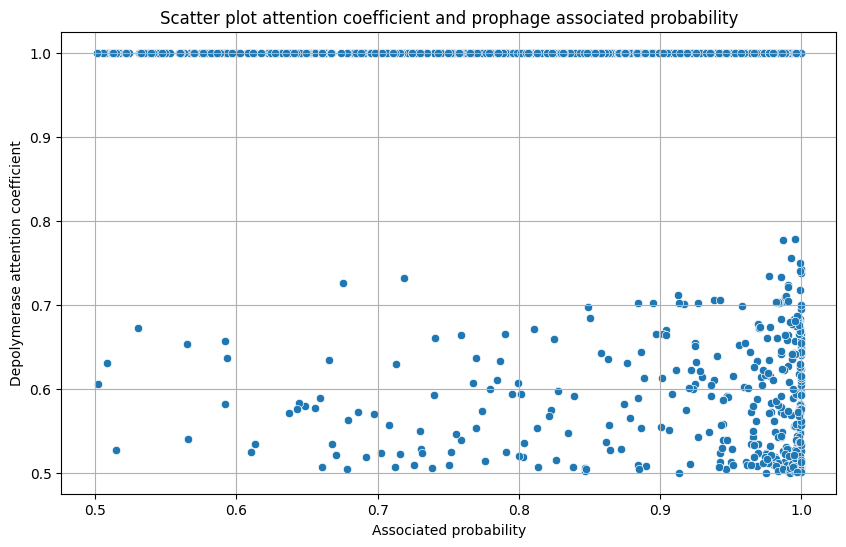

In [30]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_coeff_clean_raw, x="probability", y="attention_coefficient")

plt.title("Scatter plot attention coefficient and prophage associated probability")
plt.xlabel("Associated probability")
plt.ylabel("Depolymerase attention coefficient")

plt.grid(True)
plt.show()

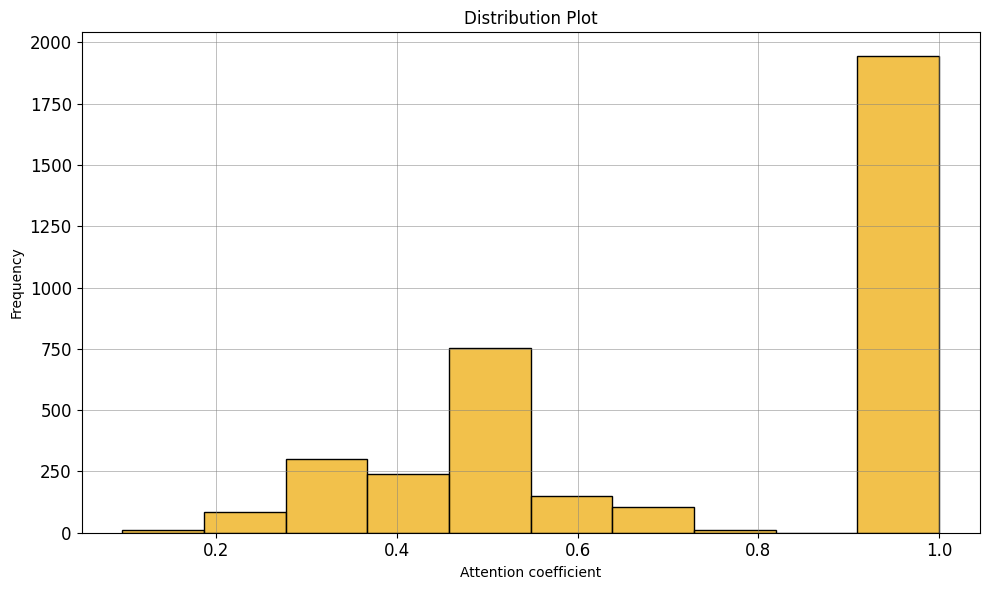

In [20]:
path_files = "/media/concha-eloko/Linux/papers/PPT/figures_draft"
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

def plot_distribution(dataframe, column, path, name, bin_width=0.05, title='Distribution Plot', 
                      xlabel='Attention coefficient', ylabel='Frequency', color='#eead0e', 
                      tick_fontsize=12):
    plt.figure(figsize=(10, 6))
    bins = 10
    
    # Plot histogram with specified color
    sns.histplot(data=dataframe, x=column, bins=bins, kde=False, color=color)
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    
    # Adjust fontsize of x and y ticks
    plt.xticks(fontsize=tick_fontsize)
    plt.yticks(fontsize=tick_fontsize)
    
    plt.tight_layout()
    plt.grid(True, linestyle='-', alpha=0.7, color='gray', linewidth=0.5)
    plt.savefig(f'{path}/{name}.svg', format="svg", transparent=True)
    plt.show()
    
plot_distribution(df_coeff, "attention_coefficient", path_files, "attention_coeff_distribution")

In [ ]:
import seaborn as sns
import pandas as pd

df = pd.DataFrame(df_coeff_clean_raw, columns=['attention_coefficient', 'probability'])

# Draw the regression plot with adjusted line appearance
#sns.regplot(x="log_Number of prophages", y="MCC score", data=df, color="#3A5A40", scatter_kws={'alpha': 0.5}, line_kws={'linewidth': 2, 'linestyle': '--'})

# Get the current x-tick labels
current_labels = plt.gca().get_xticks()

# Create new labels as "log(exponential(value))" strings
new_labels = [f"log({np.exp(label):.0f})" for label in current_labels]

# Set the new x-tick labels
plt.gca().set_xticklabels(new_labels, rotation=90)
plt.grid(True, alpha=0.2, linestyle='-')

# Setting labels and title
plt.xlabel('Number of prophages')
plt.ylabel('MCC score')
plt.title('Influence of the prophage count on the MCC score under TropiGAT')

plt.savefig('/media/concha-eloko/Linux/papers/PPT/figures_draft/scatter_plot.TropiGAT.3003.svg',format = "svg", transparent = True)  # You can change the file extension as needed

# Show the plot
plt.show()

In [3]:
df_coeff_clean_dom = df_coeff_clean.drop_duplicates(subset = ["KL_type", "domain seq"])

df_coeff_clean_dom.drop_duplicates(subset = ["domain seq"])

,KL_type,Phage,dpo_index,attention_coefficient,probability,domain seq,seq
0,KL105,GCF_900504005.1__phage0,ppt__2118,1.0,0.912764,LVGLAIDQIAQSGLSSLSVIYYSAQLFSCRSNILWISDDFENECAY...,MILVGLAIDQIAQSGLSSLSVIYYSAQLFSCRSNILWISDDFENEC...
3,KL105,GCF_900407145.1__phage13,ppt__7076,1.0,0.831640,PLPTPTQAPVPSTDIRNAVFAGAKLDEEVTGTGEFYTDRLGVKRLT...,MAEVPLPTPTQAPVPSTDIRNAVFAGAKLDEEVTGTGEFYTDRLGV...
9,KL105,GCF_922827295.1__phage12,anubis__11,1.0,0.854182,NKPRDRVLYREFSRIGKNGALTERIVKDIPDGTIGYAAIIQKEDDF...,MASIKELPRWEDEVYQIARGDKVEGGVGGIANMQAKTLAERTRYLK...
34,KL105,GCF_900506305.1__phage0,ppt__901,1.0,0.978211,IDSFDVTWFGAKGDSNEESSRINTIAIQNAINAAYVIGMAAVKFPV...,MLIAFYLFFFMGGGVLAKNNPPDPNMYSASQQSGLDSDKHTVIIVE...
35,KL105,GCF_016644075.1__phage22,ppt__1108,1.0,0.982820,IDSFDVTWFGAKGDSNEESSRINTIAIQNAINAAYVIGMAAVKFPV...,MLIAFYLFFFMGGGVLAKNNPPDPNMYSASQQSRLDSDKHTVIIVE...
...,...,...,...,...,...,...,...
9970,KL169,GCF_002186735.1__phage12,anubis__170,1.0,0.979937,VTFLTPELFGAVGDGISDDSDAIISALQLASTLKIKGVFLGKSYAI...,MYHLDNTSGVPEMPEPKDTQSISPRWFGESQEQGGISWPGADWFNI...
9972,KL169,GCF_902160775.1__phage9,anubis__187,1.0,0.957546,LDNTWNYNATAFIQDQIVEAGGYQYVVVTAEGRLPHILQRSVMGGP...,MAFNPPLGSASPAVLLDNAERLDNLVNSDAFTVPDRAGVDLDTWRG...
9973,KL169,GCF_002855375.1__phage5,anubis__699,1.0,0.935680,DLPNIQNCNSVFRGCSSLTELPEGLFARFTGATDFSSAFYGCTALA...,MTANYPASILPPNATAVERAIDRASAAALERLPVYLIRWVKDPDSC...
9974,KL169,GCF_015721495.1__phage3,anubis_return__2006,1.0,0.902269,MNNVTIEAFPEEIETTMQAAWWKPLAVKFGREVFAYIVTETAATGS...,MNNVTIEAFPEEIETTMQAAWWKPLAVKFGREVFAYIVTETAATGS...


In [4]:
df_coeff_clean_raw

,KL_type,Phage,dpo_index,attention_coefficient,probability,domain seq,seq
0,KL105,GCF_900504005.1__phage0,ppt__2118,1.000000,0.912764,LVGLAIDQIAQSGLSSLSVIYYSAQLFSCRSNILWISDDFENECAY...,MILVGLAIDQIAQSGLSSLSVIYYSAQLFSCRSNILWISDDFENEC...
2,KL105,GCF_004312865.1__phage1,ppt__767,0.633567,0.787069,IASYDVTWFGAVASDDTATYTAANTVSIQNALNAAEKAGLAAVWFP...,MYHLDNTSGVPEMPEPKETQTISTRWFGESQEQGGISWPGADWFNV...
3,KL105,GCF_900407145.1__phage13,ppt__7076,1.000000,0.831640,PLPTPTQAPVPSTDIRNAVFAGAKLDEEVTGTGEFYTDRLGVKRLT...,MAEVPLPTPTQAPVPSTDIRNAVFAGAKLDEEVTGTGEFYTDRLGV...
4,KL105,GCF_021021195.1__phage0,anubis__13,1.000000,0.779775,ALSNEVEIYRNGNRDNPRDRVLYREFSRIGRNGALTERIVKDIPTG...,MSEYDTGNPVPSASMPDAWDNMQSIDKFVNSSEETITTRTGEQLDT...
9,KL105,GCF_922827295.1__phage12,anubis__11,1.000000,0.854182,NKPRDRVLYREFSRIGKNGALTERIVKDIPDGTIGYAAIIQKEDDF...,MASIKELPRWEDEVYQIARGDKVEGGVGGIANMQAKTLAERTRYLK...
...,...,...,...,...,...,...,...
9970,KL169,GCF_002186735.1__phage12,anubis__170,1.000000,0.979937,VTFLTPELFGAVGDGISDDSDAIISALQLASTLKIKGVFLGKSYAI...,MYHLDNTSGVPEMPEPKDTQSISPRWFGESQEQGGISWPGADWFNI...
9972,KL169,GCF_902160775.1__phage9,anubis__187,1.000000,0.957546,LDNTWNYNATAFIQDQIVEAGGYQYVVVTAEGRLPHILQRSVMGGP...,MAFNPPLGSASPAVLLDNAERLDNLVNSDAFTVPDRAGVDLDTWRG...
9973,KL169,GCF_002855375.1__phage5,anubis__699,1.000000,0.935680,DLPNIQNCNSVFRGCSSLTELPEGLFARFTGATDFSSAFYGCTALA...,MTANYPASILPPNATAVERAIDRASAAALERLPVYLIRWVKDPDSC...
9974,KL169,GCF_015721495.1__phage3,anubis_return__2006,1.000000,0.902269,MNNVTIEAFPEEIETTMQAAWWKPLAVKFGREVFAYIVTETAATGS...,MNNVTIEAFPEEIETTMQAAWWKPLAVKFGREVFAYIVTETAATGS...


***
### Fun with plotting the attention coeff :

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_histogram(data):
    """
    Plot a histogram of the provided data with fixed bins between 0 and 1, with a step of 0.10.
    Args:
    data (list): A list of floats between 0 and 1.
    """
    # Define the bin edges for the histogram
    bin_edges = np.arange(0, 1.1, 0.0250)  # Bins from 0 to 1 with a step of 0.10
    # Create the histogram using seaborn
    sns.histplot(data, bins=bin_edges, kde=False, color='blue', edgecolor='black')
    # Adding labels and title for clarity
    plt.xlabel('Value')
    plt.ylabel('Count')
    plt.title('Distribution of Floats in Windows of 0.10')
    # Show the plot
    plt.show()

In [6]:
plot_histogram(test_coeff)

NameError: name 'test_coeff' is not defined

***
### Seek pairs of KL types :

In [5]:
from itertools import combinations

def generate_pairs(input_set):
    """
    Generate all possible pairs of elements from the input set.
    Args:
    input_set (set): A set of elements.
    Returns:
    list of sets: A list containing sets of all possible pairs.
    """
    return [set(pair) for pair in combinations(input_set, 2)]

def count_sets(list_of_sets):
    """
    Count occurrences of unique sets in a list of sets.
    Args:
    list_of_sets (list of sets): A list containing sets.
    Returns:
    Counter: A Counter object with counts of each unique set (converted to tuple).
    """
    # Convert each set to a tuple
    tuples = [tuple(sorted(s)) for s in list_of_sets]
    # Use Counter to count occurrences
    return Counter(tuples)

> Full depolymerase sequence

In [8]:
plural_seq = []
combinations_kltypes = []
for seq in df_coeff_clean['seq'].unique().tolist() :
    df_seq = df_coeff_clean[df_coeff_clean["seq"] == seq]["KL_type"]
    kltypes = set(df_seq.values)
    len_group = len(kltypes)
    if len_group > 1 :
        if len_group == 2 :
            combinations_kltypes.append(kltypes)
        else :
            combinations_kltypes = combinations_kltypes + generate_pairs(kltypes)
        plural_seq.append(seq)

combinations_full_seq = count_sets(combinations_kltypes)


In [10]:
len(combinations_kltypes)

502

In [11]:
(count_sets(combinations_kltypes))

Counter({('KL106', 'KL107'): 14,
         ('KL107', 'KL64'): 5,
         ('KL112', 'KL24'): 5,
         ('KL106', 'KL64'): 5,
         ('KL112', 'KL2'): 3,
         ('KL2', 'KL64'): 3,
         ('KL106', 'KL2'): 3,
         ('KL2', 'KL24'): 3,
         ('KL14', 'KL64'): 3,
         ('KL14', 'KL24'): 3,
         ('KL107', 'KL52'): 3,
         ('KL36', 'KL52'): 3,
         ('KL105', 'KL23'): 3,
         ('KL107', 'KL47'): 3,
         ('KL47', 'KL64'): 3,
         ('KL106', 'KL47'): 3,
         ('KL107', 'KL27'): 3,
         ('KL107', 'KL24'): 3,
         ('KL106', 'KL24'): 3,
         ('KL106', 'KL15'): 3,
         ('KL15', 'KL24'): 3,
         ('KL107', 'KL125'): 3,
         ('KL2', 'KL25'): 3,
         ('KL15', 'KL51'): 3,
         ('KL24', 'KL51'): 3,
         ('KL14', 'KL2'): 2,
         ('KL2', 'KL52'): 2,
         ('KL107', 'KL2'): 2,
         ('KL2', 'KL36'): 2,
         ('KL112', 'KL14'): 2,
         ('KL106', 'KL14'): 2,
         ('KL14', 'KL36'): 2,
         ('KL52', 'KL64'): 2

> Depolymerase domain : 

In [6]:
plural_seq = []
combinations_kltypes = []
for seq in df_coeff_clean_dom['seq'].unique().tolist() :
    df_seq = df_coeff_clean_dom[df_coeff_clean_dom["seq"] == seq]["KL_type"]
    kltypes = set(df_seq.values)
    len_group = len(kltypes)
    if len_group > 1 :
        if len_group == 2 :
            combinations_kltypes.append(kltypes)
        else :
            combinations_kltypes = combinations_kltypes + generate_pairs(kltypes)
        plural_seq.append(seq)

combinations_dom_seq = count_sets(combinations_kltypes)

print(len(combinations_kltypes))

497


In [7]:
combinations_dom_seq

Counter({('KL106', 'KL107'): 11,
         ('KL112', 'KL24'): 5,
         ('KL106', 'KL64'): 5,
         ('KL107', 'KL64'): 5,
         ('KL106', 'KL24'): 3,
         ('KL107', 'KL24'): 3,
         ('KL2', 'KL24'): 3,
         ('KL14', 'KL24'): 3,
         ('KL105', 'KL23'): 3,
         ('KL107', 'KL52'): 3,
         ('KL36', 'KL52'): 3,
         ('KL2', 'KL64'): 3,
         ('KL14', 'KL64'): 3,
         ('KL47', 'KL64'): 3,
         ('KL106', 'KL2'): 3,
         ('KL106', 'KL47'): 3,
         ('KL107', 'KL27'): 3,
         ('KL107', 'KL47'): 3,
         ('KL112', 'KL2'): 3,
         ('KL15', 'KL24'): 3,
         ('KL2', 'KL25'): 3,
         ('KL24', 'KL51'): 3,
         ('KL15', 'KL51'): 3,
         ('KL23', 'KL24'): 2,
         ('KL24', 'KL64'): 2,
         ('KL24', 'KL36'): 2,
         ('KL24', 'KL47'): 2,
         ('KL105', 'KL24'): 2,
         ('KL106', 'KL23'): 2,
         ('KL107', 'KL23'): 2,
         ('KL23', 'KL47'): 2,
         ('KL52', 'KL64'): 2,
         ('KL106', 'KL52'):

In [8]:
data = dict(combinations_dom_seq)

with open("/media/concha-eloko/Linux/papers/PPT/TropiGAT_network_file.0802.tsv", "w") as outfile :
    for assoc in data : 
        outfile.write(f"{assoc[0]}\t{assoc[1]}\t{data[assoc]}\n")

with open("/media/concha-eloko/Linux/papers/PPT/TropiGAT_network_file.0802.lvl1.tsv", "w") as outfile :
    for assoc in data : 
        if data[assoc] > 1 :
            outfile.write(f"{assoc[0]}\t{assoc[1]}\t{data[assoc]}\n")

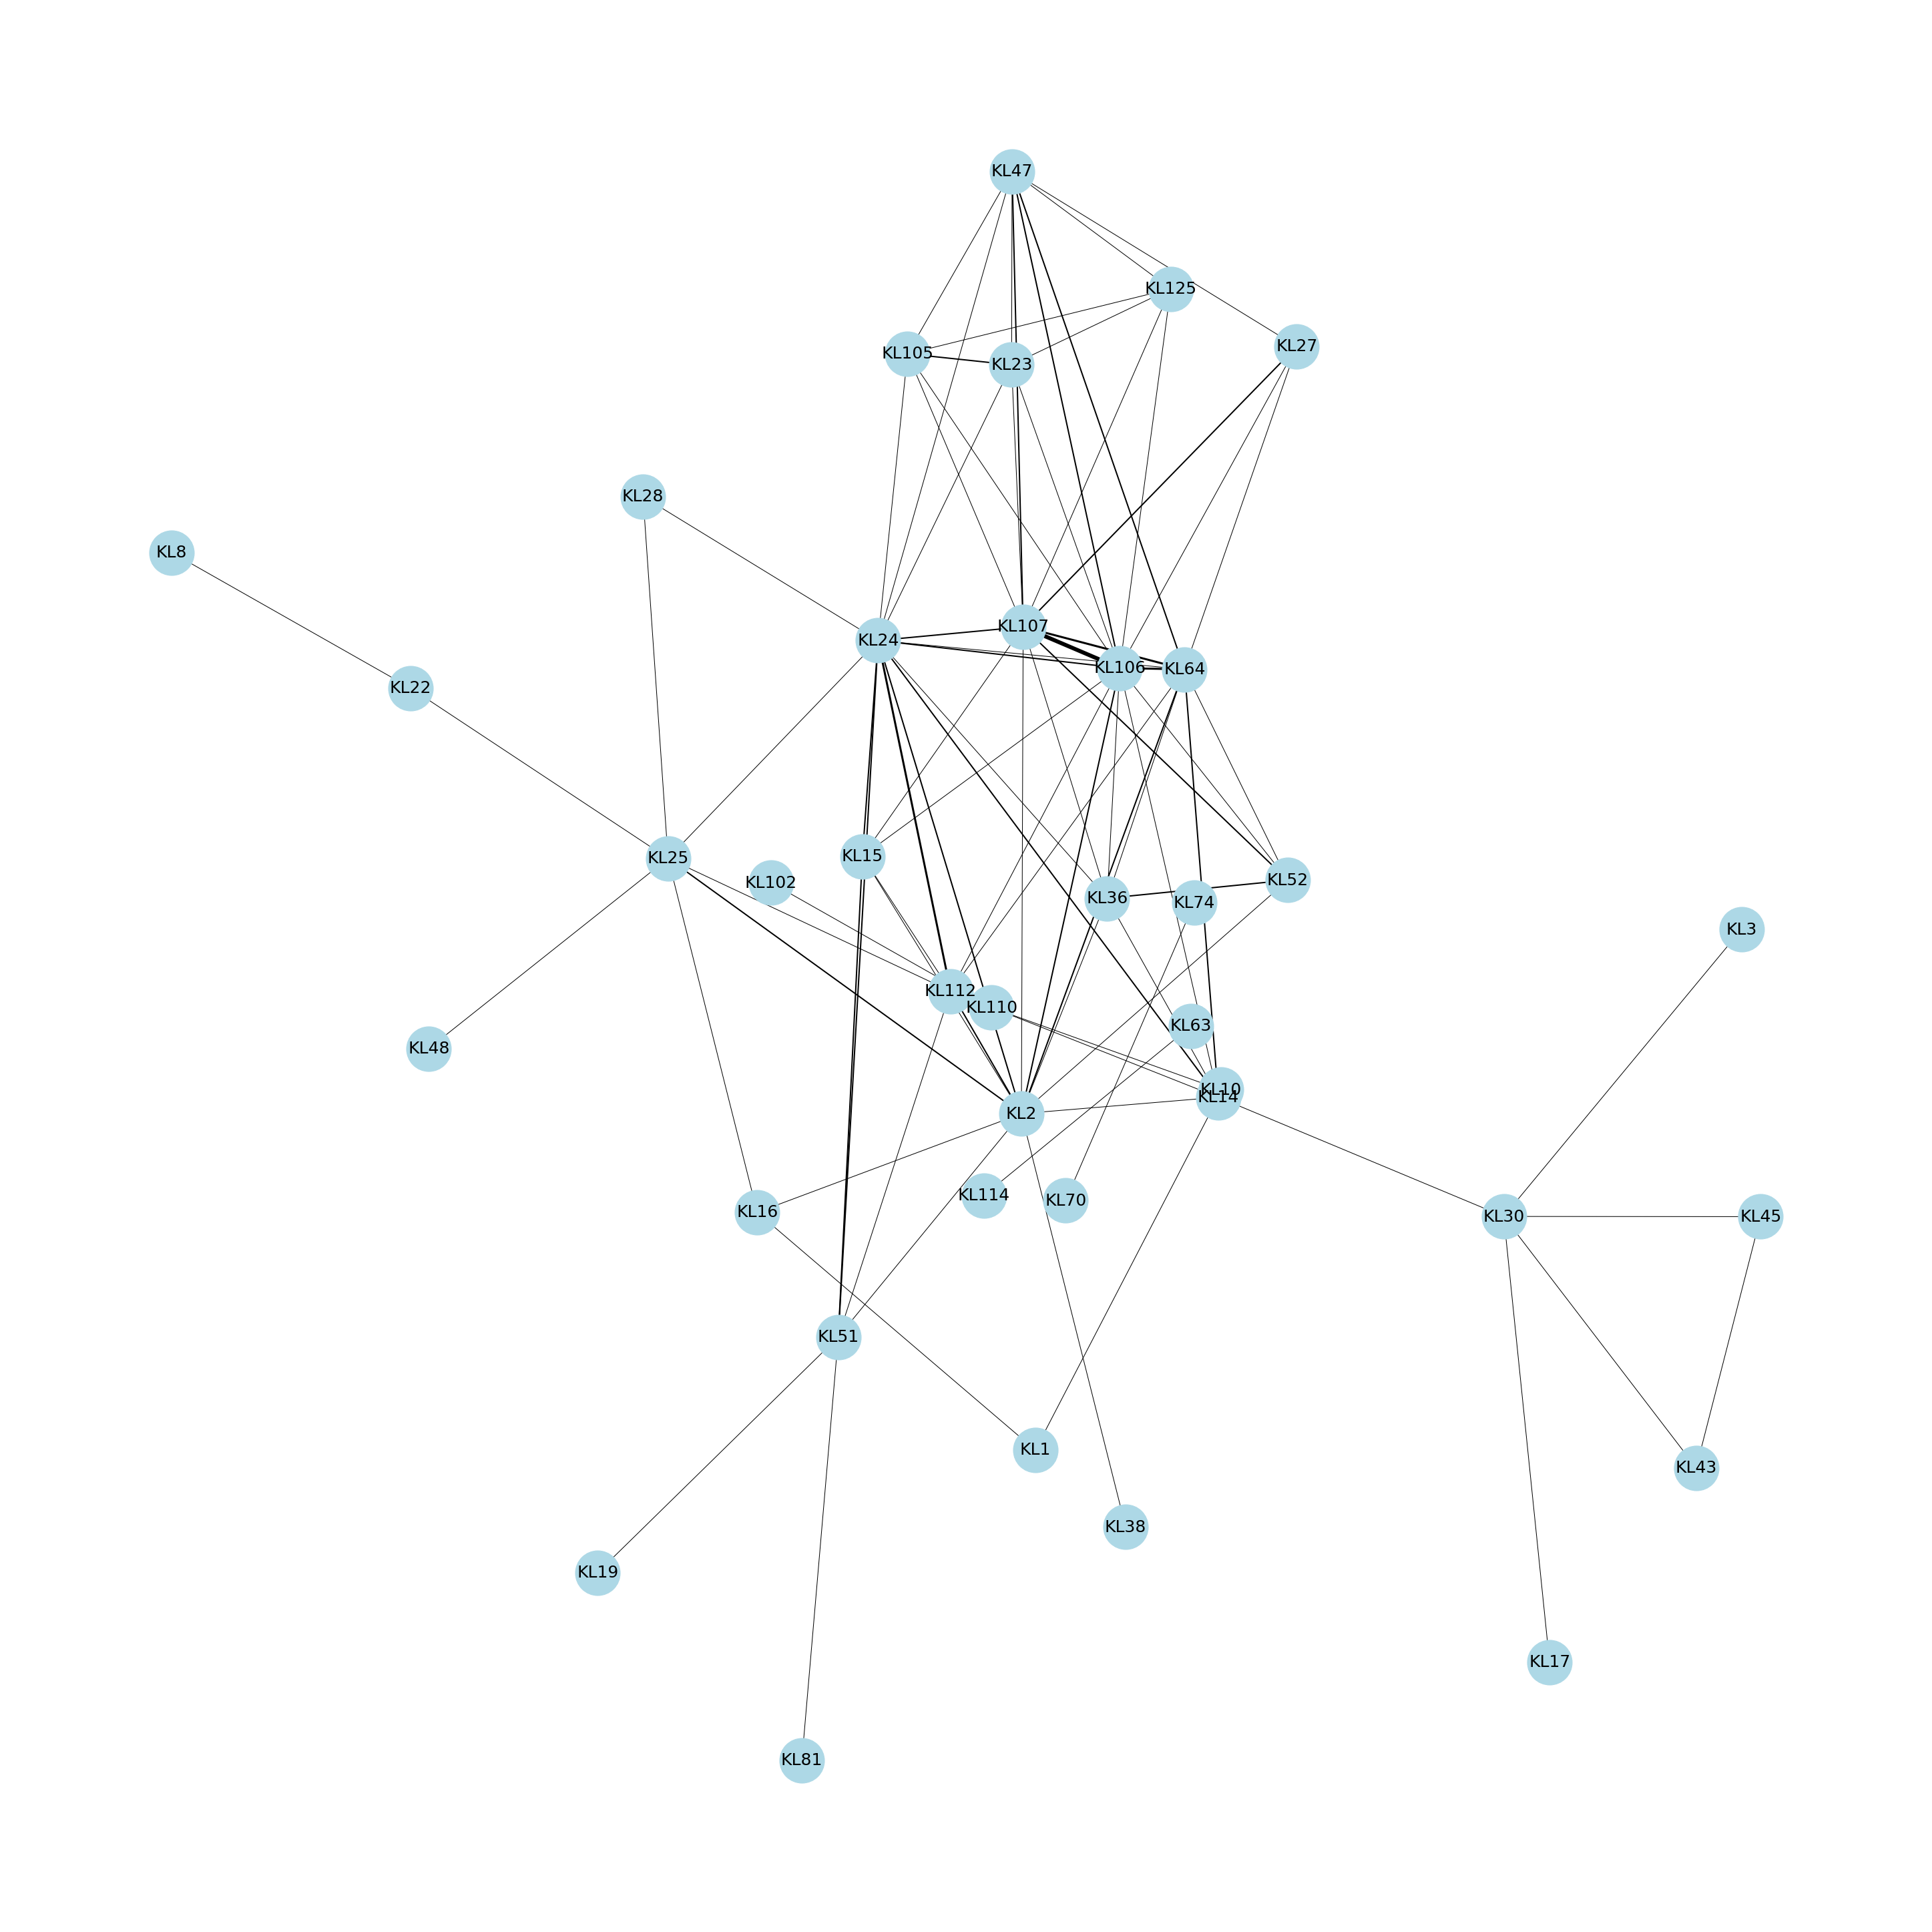

In [36]:
import networkx as nx
import matplotlib.pyplot as plt

# create an empty directed graph
G = nx.Graph()

# example dictionary with tuples as keys and their prevalence as values
data = dict(combinations_dom_seq)
data_graph = [(key[0], key[1], value) for key,value in data.items() if value > 1]

# add edges to the graph with weights corresponding to prevalence values
G.add_weighted_edges_from(data_graph)

# get a dictionary of edge weights
edge_weights = nx.get_edge_attributes(G, 'weight')

# define a function to scale edge weights to widths
def scale_width(weight):
    # scale weights to widths between 1 and 10
    return int(1 + weight * 5 / max(edge_weights.values()))

# set the figure size
plt.figure(figsize=(40, 40)) 

# draw the graph with edge widths scaled according to weights
pos = nx.kamada_kawai_layout(G)
#pos = nx.spring_layout(G)

nx.draw(G, pos=pos, node_color='lightblue', with_labels=True, width=[scale_width(w) for w in edge_weights.values()],font_size=25, node_size=4500)

# add edge labels
#edge_labels = nx.get_edge_attributes(G, 'weight')
#nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

# display the plot
plt.savefig('/media/concha-eloko/Linux/papers/PPT/figures_draft/network_KLtypes.TorpiGAT.0802.svg',format = "svg", transparent = True) 
plt.show()

In [ ]:
data_tropiseq = {('KL137', 'KL123'): 1,
 ('KL47', 'KL64'): 2,
 ('KL21', 'KL39'): 1,
 ('KL21', 'KL166'): 1,
 ('KL21', 'KL24'): 1,
 ('KL21', 'KL48'): 1,
 ('KL21', 'KL112'): 1,
 ('KL39', 'KL166'): 1,
 ('KL39', 'KL24'): 1,
 ('KL39', 'KL48'): 1,
 ('KL39', 'KL112'): 1,
 ('KL166', 'KL24'): 1,
 ('KL166', 'KL48'): 1,
 ('KL166', 'KL112'): 1,
 ('KL24', 'KL48'): 1,
 ('KL24', 'KL112'): 1,
 ('KL48', 'KL112'): 1,
 ('KL47', 'KL107'): 1,
 ('KL47', 'KL105'): 1,
 ('KL47', 'KL41'): 1,
 ('KL47', 'KL15'): 1,
 ('KL47', 'KL36'): 1,
 ('KL47', 'KL164'): 1,
 ('KL47', 'KL24'): 1,
 ('KL47', 'KL6'): 1,
 ('KL47', 'KL13'): 1,
 ('KL47', 'KL106'): 1,
 ('KL47', 'KL103'): 1,
 ('KL47', 'KL108'): 1,
 ('KL107', 'KL105'): 1,
 ('KL107', 'KL41'): 1,
 ('KL107', 'KL64'): 1,
 ('KL107', 'KL15'): 1,
 ('KL107', 'KL36'): 1,
 ('KL107', 'KL164'): 2,
 ('KL107', 'KL24'): 1,
 ('KL107', 'KL6'): 1,
 ('KL107', 'KL13'): 1,
 ('KL107', 'KL106'): 2,
 ('KL107', 'KL103'): 1,
 ('KL107', 'KL108'): 1,
 ('KL105', 'KL41'): 1,
 ('KL105', 'KL64'): 1,
 ('KL105', 'KL15'): 1,
 ('KL105', 'KL36'): 1,
 ('KL105', 'KL164'): 1,
 ('KL105', 'KL24'): 1,
 ('KL105', 'KL6'): 1,
 ('KL105', 'KL13'): 1,
 ('KL105', 'KL106'): 1,
 ('KL105', 'KL103'): 1,
 ('KL105', 'KL108'): 1,
 ('KL41', 'KL64'): 1,
 ('KL41', 'KL15'): 1,
 ('KL41', 'KL36'): 1,
 ('KL41', 'KL164'): 2,
 ('KL41', 'KL24'): 1,
 ('KL41', 'KL6'): 2,
 ('KL41', 'KL13'): 1,
 ('KL41', 'KL106'): 1,
 ('KL41', 'KL103'): 1,
 ('KL41', 'KL108'): 1,
 ('KL64', 'KL15'): 1,
 ('KL64', 'KL36'): 1,
 ('KL64', 'KL164'): 1,
 ('KL64', 'KL24'): 1,
 ('KL64', 'KL6'): 1,
 ('KL64', 'KL13'): 1,
 ('KL64', 'KL106'): 1,
 ('KL64', 'KL103'): 1,
 ('KL64', 'KL108'): 1,
 ('KL15', 'KL36'): 1,
 ('KL15', 'KL164'): 1,
 ('KL15', 'KL24'): 1,
 ('KL15', 'KL6'): 1,
 ('KL15', 'KL13'): 1,
 ('KL15', 'KL106'): 1,
 ('KL15', 'KL103'): 1,
 ('KL15', 'KL108'): 1,
 ('KL36', 'KL164'): 1,
 ('KL36', 'KL24'): 1,
 ('KL36', 'KL6'): 1,
 ('KL36', 'KL13'): 1,
 ('KL36', 'KL106'): 1,
 ('KL36', 'KL103'): 1,
 ('KL36', 'KL108'): 1,
 ('KL164', 'KL24'): 1,
 ('KL164', 'KL6'): 3,
 ('KL164', 'KL13'): 1,
 ('KL164', 'KL106'): 1,
 ('KL164', 'KL103'): 1,
 ('KL164', 'KL108'): 1,
 ('KL24', 'KL6'): 1,
 ('KL24', 'KL13'): 1,
 ('KL24', 'KL106'): 1,
 ('KL24', 'KL103'): 1,
 ('KL24', 'KL108'): 1,
 ('KL6', 'KL13'): 1,
 ('KL6', 'KL106'): 1,
 ('KL6', 'KL103'): 1,
 ('KL6', 'KL108'): 1,
 ('KL13', 'KL106'): 1,
 ('KL13', 'KL103'): 1,
 ('KL13', 'KL108'): 1,
 ('KL106', 'KL103'): 1,
 ('KL106', 'KL108'): 1,
 ('KL103', 'KL108'): 1,
 ('KL23', 'KL28'): 1,
 ('KL26', 'KL74'): 1,
 ('KL67', 'KL17'): 2,
 ('KL20', 'KL124'): 1,
 ('KL20', 'KL137'): 1,
 ('KL20', 'KL16'): 1,
 ('KL20', 'KL48'): 1,
 ('KL124', 'KL137'): 1,
 ('KL124', 'KL16'): 1,
 ('KL124', 'KL48'): 1,
 ('KL137', 'KL16'): 1,
 ('KL137', 'KL48'): 1,
 ('KL16', 'KL48'): 1,
 ('KL5', 'KL117'): 1,
 ('KL9', 'KL149'): 1,
 ('KL127', 'KL159'): 2,
 ('KL3', 'KL35'): 1,
 ('KL14', 'KL31'): 1,
 ('KL58', 'KL159'): 1,
 ('KL58', 'KL35'): 1,
 ('KL159', 'KL35'): 1,
 ('KL21', 'KL124'): 1,
 ('KL114', 'KL159'): 1,
 ('KL105', 'KL9'): 1,
 ('KL152', 'KL26'): 1,
 ('KL152', 'KL137'): 1,
 ('KL26', 'KL137'): 1,
 ('KL20', 'KL51'): 1,
 ('KL20', 'KL54'): 1,
 ('KL51', 'KL54'): 1,
 ('KL1', 'KL164'): 1,
 ('KL1', 'KL6'): 1,
 ('KL107', 'KL67'): 1,
 ('KL67', 'KL106'): 1,
 ('KL114', 'KL113'): 1,
 ('KL114', 'KL54'): 1,
 ('KL114', 'KL63'): 1,
 ('KL113', 'KL54'): 1,
 ('KL113', 'KL63'): 1,
 ('KL54', 'KL63'): 1}



In [33]:
with open("/media/concha-eloko/Linux/papers/PPT/Tropiseq_network_file.0802.tsv", "w") as outfile :
    for assoc in data_tropiseq : 
        outfile.write(f"{assoc[0]}\t{assoc[1]}\t{data_tropiseq[assoc]}\n")



NameError: name 'data_tropiseq' is not defined

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# create an empty directed graph
G = nx.Graph()

# example dictionary with tuples as keys and their prevalence as values
data = data_tropiseq
data_graph = [(key[0], key[1], value) for key,value in data.items() if value > 0]

# add edges to the graph with weights corresponding to prevalence values
G.add_weighted_edges_from(data_graph)

# get a dictionary of edge weights
edge_weights = nx.get_edge_attributes(G, 'weight')

# define a function to scale edge weights to widths
def scale_width(weight):
    # scale weights to widths between 1 and 10
    return int(1 + weight * 5 / max(edge_weights.values()))

# set the figure size
plt.figure(figsize=(40, 40)) 

# draw the graph with edge widths scaled according to weights
pos = nx.kamada_kawai_layout(G)
#pos = nx.spring_layout(G)

nx.draw(G, pos=pos, node_color='lightblue', with_labels=True, width=[scale_width(w) for w in edge_weights.values()],font_size=25, node_size=4500)

# add edge labels
#edge_labels = nx.get_edge_attributes(G, 'weight')
#nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

# display the plot
plt.savefig('/media/concha-eloko/Linux/papers/PPT/figures_draft/network_KLtypes.TropiSeq.svg',format = "svg", transparent = True) 
plt.show()

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import colors

# create an empty directed graph
G = nx.Graph()

# example dictionary with tuples as keys and their prevalence as values
data = dict(count_sets(combinations_kltypes))
data_graph = [(key[0], key[1], value) for key, value in data.items()]

# add edges to the graph with weights corresponding to prevalence values
G.add_weighted_edges_from(data_graph)

# get a dictionary of edge weights
edge_weights = nx.get_edge_attributes(G, 'weight')

# set the figure size
plt.figure(figsize=(20, 20))  # Adjust the values (width, height) as needed

# draw the graph with edge colors representing weights, set node label size, and adjust node size
pos = nx.spring_layout(G)

# Define a custom colormap with darker colors for higher weights
cmap = colors.LinearSegmentedColormap.from_list('custom_blues', ['#2c7bb6', '#abd9e9', '#74add1', '#4575b4', '#313695'])

# Normalize the edge weights to be in the range [0, 1]
norm = colors.Normalize(vmin=min(edge_weights.values()), vmax=max(edge_weights.values()))

# Create a colormap scalar mappable
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

# Draw the edges with colors based on weights
nx.draw(G, pos=pos, node_color='lightblue', with_labels=True, edge_color=[cmap(norm(weight)) for weight in edge_weights.values()], width=2, font_size=10, node_size=600)

# Add a colorbar to the plot
cbar = plt.colorbar(sm, orientation='vertical', pad=0.01, aspect=20)
cbar.set_label('Edge Weight')

# display the plot
plt.show()

***
### Check the fold of the assigned dpos


In [ ]:
DF_info_light_folded = pd.read_csv(f"{path_work}/TropiGAT_v2.light_folded.tsv", sep = "\t", header = 0)


In [ ]:
DF_info_light_folded.drop_duplicates(subset = ["seq"])

In [ ]:
assgined_folds = []

for _, seq in enumerate(df_coeff["seq"].unique().tolist()) : 
    fold = DF_info_light_folded[DF_info_light_folded["seq"] == seq]["Fold"].values[0]
    assgined_folds.append(fold)


In [ ]:
Counter(assgined_folds)

In [ ]:
Counter(DF_info_light_folded.drop_duplicates(subset = ["seq"])["Fold"])

In [ ]:
fold_plural = []

for _, seq in enumerate(plural_seq) : 
    fold = DF_info_light_folded[DF_info_light_folded["seq"] == seq]["Fold"].values[0]
    fold_plural.append(fold)

In [ ]:
Counter(fold_plural)

In [ ]:
714/3933*100

In [ ]:
23/100*100

In [ ]:
len(fold_plural)

***
# Make chimera :

In [ ]:
# Beta helix : #c6aa58ff
# 6-bladed-propeller : #8d0801ff
# Alpha/Beta hydrolase : #b3aa99ff
# TIM beta/alpha-barrel : #172b23f0

color #1:   #a40505 target r

# Alpha/Beta hydrolase fold : ppt__116
color #1:47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496 #b3aa99ff target r
color #3 #b3aa99ff target r
save /media/concha-eloko/Linux/papers/PPT/figures_draft/alpha_beta_hydrolase.png format png width 5000 height 5000 transparentBackground true

# Done
# Beta helix minibatch__460: 
color #1:294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669  #c6aa58ff target r
color #1 #c6aa58ff target r
save /media/concha-eloko/Linux/papers/PPT/figures_draft/beta_helix.png format png width 5000 height 5000 transparentBackground true

# Done
# TIM beta/alpha-barrel 3091.pdb: 
color #2:225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472 #172b23f0 target r
color #2 #172b23f0 target r
save /media/concha-eloko/Linux/papers/PPT/figures_draft/tim_beta_alpha_barrel.png format png width 5000 height 5000 transparentBackground true

# Done
# 6-bladed beta-propeller 3091.pdb: 
color #3:171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437 #8d0801ff target r
color #1 #8d0801ff target r
save /media/concha-eloko/Linux/papers/PPT/figures_draft/bladed_beta_propeller.png format png width 5000 height 5000 transparentBackground true



In [9]:
(288 + 269 + 242 + 204 + 190 + 152 + 144 + 145 + 130)/8891 *100

19.840287931616242

In [12]:
3889 / 8891 *100

43.74086154538297

In [ ]:
KL24 (288), KL25 (269), KL102 (242), KL15 (204), KL1 (190), KL62 (152), KL51 (144), KL3 (145), and KL14 (130)

In [10]:
(1121 + 897 + 551 + 488 + 481 + 351) /8891 *100

43.74086154538297

In [ ]:
(1,121), KL64 (897), KL47 (551), KL106 (488), KL17 (481) and KL2 (351). 
Another group consisting of KL types assigned to between 120 and 300 prophages comprised 11 KL types with KL24 (288)


In [13]:
4526/8891 *100

50.90540996513329

In [11]:
476 / 8891 *100

5.353728489483748